In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.stats import norm, kstest, zscore
from sklearn.ensemble import IsolationForest


# UL-PURDUE

## Limpeza e preparação

- Corrente negativa --> descarga
- Corrente positiva --> carga

In [19]:
# Header completo:
# Date_Time,Test_Time (s),Cycle_Index,Current (A),Voltage (V),Charge_Capacity (Ah),Discharge_Capacity (Ah),Charge_Energy (Wh),Discharge_Energy (Wh),Environment_Temperature (C),Cell_Temperature (C)
df = pd.read_csv('../Battery_Archive_Data/UL-Purdue/3.40_UL-PUR_CF10DPA_pouch_NCA_25C_0-100_1-1C_n_timeseries_data.csv')

# Apenas features de interesse são mantidas
# Obs: Envoironment_Temperature (C) poderia ser relevante, mas tem todos os valores nulos. Então, é removida
df = df[["Cycle_Index", "Test_Time (s)", "Current (A)", "Voltage (V)", "Discharge_Capacity (Ah)", "Cell_Temperature (C)"]]

# Mantem apenas as linhas em que a bateria está descarregando, ou seja, corrente < 0
df = df[df['Current (A)'] < 0]

# Remove valores para Cell_Temperature < 1 (incorretos)
#df = df[df['Cell_Temperature (C)'] >= 1]

display(df)
display(df.describe())

,Cycle_Index,Test_Time (s),Current (A),Voltage (V),Discharge_Capacity (Ah),Cell_Temperature (C)
3640,1.0,4736.728,-3.298,4.095,0.000,NaN
3641,1.0,4737.742,-3.298,4.092,0.001,NaN
3642,1.0,4738.756,-3.299,4.089,0.002,NaN
3643,1.0,4739.770,-3.298,4.087,0.003,NaN
3644,1.0,4740.784,-3.299,4.085,0.004,NaN
...,...,...,...,...,...,...
4304496,485.0,5513319.500,-3.299,2.726,3.009,NaN
4304497,485.0,5513320.514,-3.298,2.720,3.010,NaN
4304498,485.0,5513321.528,-3.299,2.713,3.011,NaN
4304499,485.0,5513322.543,-3.299,2.705,3.012,NaN


,Cycle_Index,Test_Time (s),Current (A),Voltage (V),Discharge_Capacity (Ah),Cell_Temperature (C)
count,1.469894e+06,1.469894e+06,1.469894e+06,1.469894e+06,1.469894e+06,0.0
mean,2.469120e+02,2.825558e+06,-3.298849e+00,3.595584e+00,1.506343e+00,NaN
std,1.424258e+02,1.615842e+06,1.033147e-02,2.439519e-01,8.765028e-01,NaN
min,1.000000e+00,4.736728e+03,-5.758000e+00,2.699000e+00,0.000000e+00,NaN
25%,1.100000e+02,1.279094e+06,-3.299000e+00,3.463000e+00,7.500000e-01,NaN
50%,2.540000e+02,2.916530e+06,-3.299000e+00,3.612000e+00,1.500000e+00,NaN
75%,3.700000e+02,4.214854e+06,-3.299000e+00,3.759000e+00,2.249000e+00,NaN
max,4.850000e+02,5.513323e+06,-1.000000e-03,4.182000e+00,3.207000e+00,NaN


## Visualização

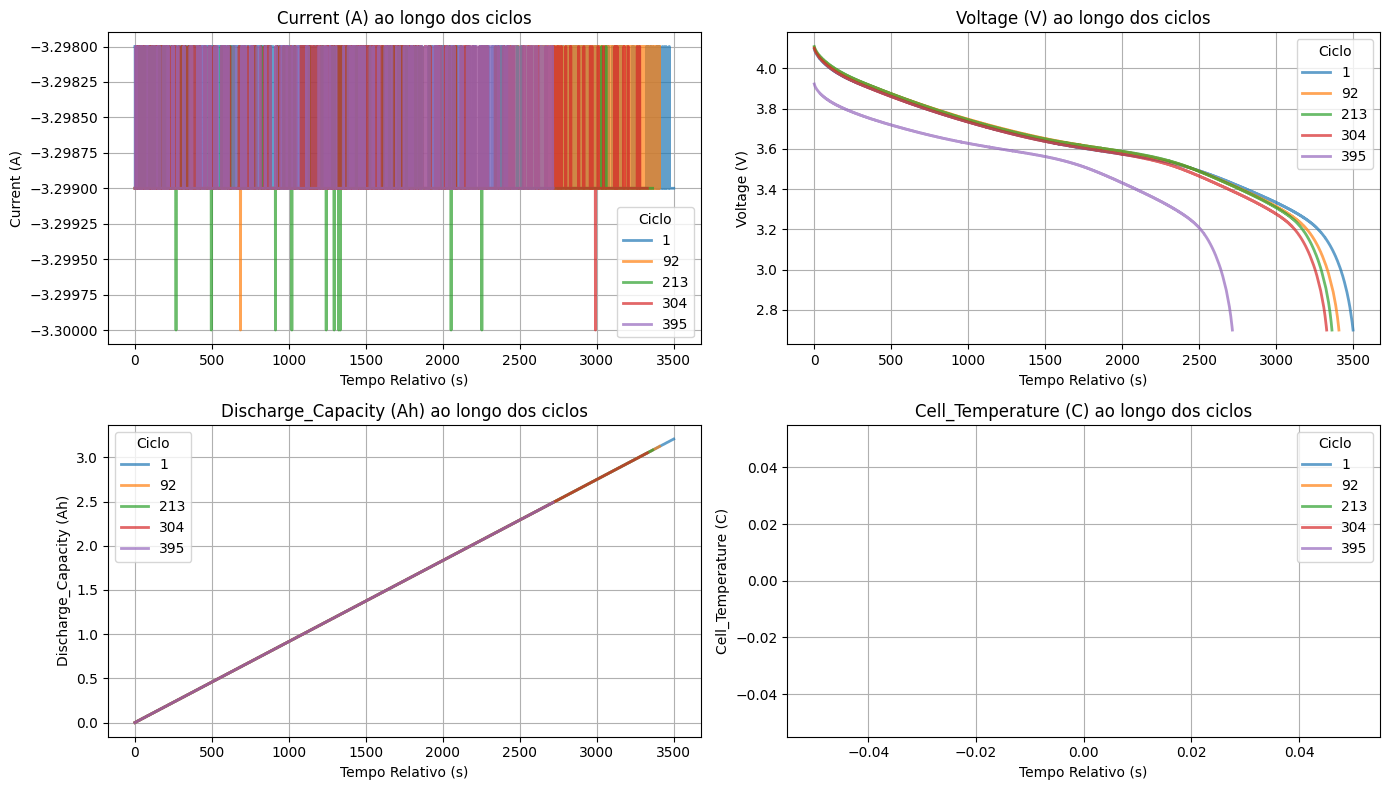

In [20]:
# Lista de features que deseja analisar (exceto "Cycle_Index")
features = ["Current (A)", "Voltage (V)", "Discharge_Capacity (Ah)", "Cell_Temperature (C)"]

# Ciclos únicos e ordenados
cycles = df["Cycle_Index"].unique()
cycles.sort()
NumCyclesPlot = 5

# Seleciona 'NumCyclesPlot' ciclos igualmente espaçados para plotar
if len(cycles) > NumCyclesPlot:
    cycles = cycles[::len(cycles)//NumCyclesPlot] # // --> Divisão inteira

# Cria os subplots com layout 2x2
fig, axs = plt.subplots(2, 2, figsize=(14, 8))
axs = axs.flatten()  # Facilita a iteração

# Itera sobre cada feature e sobre os ciclos para plotar os dados
for i, feature in enumerate(features):
    ax = axs[i]
    for cycle in cycles:
        # Seleciona os dados do ciclo e calcula o tempo relativo
        df_cycle = df[df["Cycle_Index"] == cycle].copy()
        df_cycle['Tempo_Relativo (s)'] = df_cycle["Test_Time (s)"] - df_cycle["Test_Time (s)"].min()
        
        # Plota a feature em função do tempo relativo
        ax.plot(df_cycle['Tempo_Relativo (s)'], df_cycle[feature], alpha=0.7, label=f'{int(cycle)}', linewidth=2.0)

    ax.set_title(f'{feature} ao longo dos ciclos')
    ax.set_xlabel('Tempo Relativo (s)')
    ax.set_ylabel(feature)
    ax.grid(True)
    ax.legend(title="Ciclo", loc='best')

plt.tight_layout()
plt.show()


## Análise de SOH

$$
\text{SOH} = \frac{\text{capacidade\_atual}}{\text{capacidade\_inicial}}
$$

- $CapacidadeInicial$ é a capacidade nominal, a maior considerando todo o histórico da bateria
- $CapacidadeAtual$ é a maior capacidade do ciclo

In [21]:
# Capacidade nominal (máxima global)
nominal_capacity = 3.40 #df['Discharge_Capacity (Ah)'].max()
print(f'Capacidade total de descarga: {nominal_capacity} Ah')

# Para cada ciclo, extrai a maior capacidade 
# (cycles_capacity é uma série do Pandas)
cycles_capacity = df.groupby('Cycle_Index')['Discharge_Capacity (Ah)'].max()
cycles_capacity = cycles_capacity.reset_index() # transforma em dataframe
cycles_capacity.columns = ['Cycle_Index', 'Max_Discharge_Capacity']
cycles_capacity['SOH_discharge'] = (cycles_capacity['Max_Discharge_Capacity'] / nominal_capacity)
display(cycles_capacity)

Capacidade total de descarga: 3.4 Ah


,Cycle_Index,Max_Discharge_Capacity,SOH_discharge
0,1.0,3.207,0.943235
1,2.0,3.203,0.942059
2,3.0,3.205,0.942647
3,4.0,3.206,0.942941
4,5.0,3.203,0.942059
...,...,...,...
450,481.0,3.013,0.886176
451,482.0,3.012,0.885882
452,483.0,3.015,0.886765
453,484.0,3.014,0.886471


In [22]:
# Seleciona as features de interesse e agrupa por ciclo
df_grouped = df[['Cycle_Index', 'Cell_Temperature (C)']]
df_grouped = df_grouped.groupby('Cycle_Index', as_index=False).mean() # Média será usada para a temperatura

# Adição do SOH calculado em ciclos_capacity
df_grouped['SOH_discharge'] = cycles_capacity['SOH_discharge']

display(df_grouped)
display(df_grouped.describe())

,Cycle_Index,Cell_Temperature (C),SOH_discharge
0,1.0,NaN,0.943235
1,2.0,NaN,0.942059
2,3.0,NaN,0.942647
3,4.0,NaN,0.942941
4,5.0,NaN,0.942059
...,...,...,...
450,481.0,NaN,0.886176
451,482.0,NaN,0.885882
452,483.0,NaN,0.886765
453,484.0,NaN,0.886471


,Cycle_Index,Cell_Temperature (C),SOH_discharge
count,455.000000,0.0,455.000000
mean,250.087912,NaN,0.881878
std,141.850393,NaN,0.059227
min,1.000000,NaN,0.724706
25%,114.500000,NaN,0.888971
50%,258.000000,NaN,0.897353
75%,371.500000,NaN,0.909118
max,485.000000,NaN,0.943235


### Outliers

In [23]:
# Técnica estatística para identificar outliers em um conjunto de dados, calculando o intervalo entre o primeiro quartil (Q1) e o terceiro quartil (Q3), e usando para definir limites superiores e inferiores. Outliers são definidos como pontos que caem abaixo de Q1 - 1.5 * IQR ou acima de Q3 + 1.5 * IQR. Este método é robusto contra a não normalidade dos dados, sendo útil para distribuições assimétricas.
def rmv_outliers_iqr(df: pd.DataFrame, column_name: str) -> pd.DataFrame:
    # Calculate the first and third quartiles
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    
    # Calculate the Interquartile Range (IQR)
    IQR = Q3 - Q1
    
    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter the DataFrame to keep only the values within the bounds
    filtered_df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    
    return filtered_df

In [24]:
# Algoritmo de machine learning não supervisionado usado para detecção de anomalias, que identifica outliers isolando-os a partir de partições aleatórias em um conjunto de árvores de decisão
def rmv_outliers_isolation_forest(df: pd.DataFrame, column_name: str, contamin='auto') -> pd.DataFrame:
    model = IsolationForest(contamination=contamin, random_state=123)
    
    # Fit the model and predict outliers. The data needs to be reshaped to a 2D array.
    predictions = model.fit_predict(df[[column_name]].values)
    
    # Filter the DataFrame to keep only the inliers (predictions == 1)
    filtered_df = df[predictions == 1]
    
    return filtered_df

In [25]:
def rmv_outliers_zscore(df: pd.DataFrame, column_name: str, threshold: float = 3.0) -> pd.DataFrame:
    # Calculate the Z-scores of the column
    z_scores = np.abs(zscore(df[column_name]))
    
    # Create a boolean mask to filter out outliers
    inlier_mask = z_scores <= threshold
    
    # Filter the DataFrame to keep only the inliers
    filtered_df = df[inlier_mask]
    
    return filtered_df

In [26]:
def ensure_non_increasing(df: pd.DataFrame, column_name: str) -> pd.DataFrame:
    # Create a boolean mask where True indicates a valid decreasing or equal step
    is_decreasing = df[column_name].diff().fillna(-1) <= 0
    
    # Filter the DataFrame to keep only the monotonic values
    filtered_df = df[is_decreasing]
    
    return filtered_df

In [27]:
def rmv_sharp_jump(df: pd.DataFrame, column_name: str, threshold: float, repeat=1) -> pd.DataFrame:
    for _ in range(repeat):
        # diff -> a diferença entre os valores consecutivos
        # abs -> o valor absoluto para tratar subidas e quedas
        # shift(-1) -> para que a diferença seja aplicada ao ponto de origem do salto
        # fillna(0) -> trata o último valor (que é NaN após o shift) com 0 para que ele seja mantido
        shifted_diff = df[column_name].diff().abs().shift(-1).fillna(0)
        
        is_not_sharp_jump = shifted_diff <= threshold
        df = df[is_not_sharp_jump]
    
    return df

In [28]:
# Remoção de outliers e valores crescentes
df_IsolForest = ensure_non_increasing(df_grouped, 'SOH_discharge')
df_IsolForest = rmv_outliers_isolation_forest(df_IsolForest, 'SOH_discharge')

df_IQR = ensure_non_increasing(df_grouped, 'SOH_discharge')
df_IQR = rmv_outliers_iqr(df_IQR, 'SOH_discharge')

df_ZScore = ensure_non_increasing(df_grouped, 'SOH_discharge')
df_ZScore = rmv_outliers_zscore(df_ZScore, 'SOH_discharge', threshold=1.5)

df_ZScore = rmv_sharp_jump(df_ZScore, 'SOH_discharge', threshold=0.05, repeat=2) # 5% de SOH

display(df_grouped)
display(df_IsolForest)
display(df_IQR)
display(df_ZScore)

,Cycle_Index,Cell_Temperature (C),SOH_discharge
0,1.0,NaN,0.943235
1,2.0,NaN,0.942059
2,3.0,NaN,0.942647
3,4.0,NaN,0.942941
4,5.0,NaN,0.942059
...,...,...,...
450,481.0,NaN,0.886176
451,482.0,NaN,0.885882
452,483.0,NaN,0.886765
453,484.0,NaN,0.886471


,Cycle_Index,Cell_Temperature (C),SOH_discharge
59,60.0,NaN,0.927059
60,61.0,NaN,0.926765
62,63.0,NaN,0.926765
64,65.0,NaN,0.925294
65,66.0,NaN,0.925294
...,...,...,...
435,466.0,NaN,0.887647
436,467.0,NaN,0.887353
438,469.0,NaN,0.887647
445,476.0,NaN,0.887059


,Cycle_Index,Cell_Temperature (C),SOH_discharge
0,1.0,NaN,0.943235
1,2.0,NaN,0.942059
4,5.0,NaN,0.942059
5,6.0,NaN,0.941765
6,7.0,NaN,0.941471
...,...,...,...
446,477.0,NaN,0.886765
447,478.0,NaN,0.885882
451,482.0,NaN,0.885882
453,484.0,NaN,0.886471


,Cycle_Index,Cell_Temperature (C),SOH_discharge
0,1.0,NaN,0.943235
1,2.0,NaN,0.942059
4,5.0,NaN,0.942059
5,6.0,NaN,0.941765
6,7.0,NaN,0.941471
...,...,...,...
446,477.0,NaN,0.886765
447,478.0,NaN,0.885882
451,482.0,NaN,0.885882
453,484.0,NaN,0.886471


### [numpy.interp() parameters](https://numpy.org/doc/2.1/reference/generated/numpy.interp.html):
- `x`: _array_like_ . The x-coordinates at which to evaluate the interpolated values.

- `xp`: _1-D sequence of floats_. The x-coordinates of the data points, must be increasing if argument period is not specified. Otherwise, xp is internally sorted after normalizing the periodic boundaries with xp = xp % period.

- `fp`: _1-D sequence of float or complex_. The y-coordinates of the data points, same length as xp.

Returns the one-dimensional piecewise linear interpolant to a function with given discrete data points (xp, fp), evaluated at x:
- `y`: float or complex (corresponding to fp) or ndarray. The interpolated values, same shape as x.

In [29]:
def interpolate_soh(df: pd.DataFrame, soh_column: str, cycles_column: str) -> pd.DataFrame:
    # Define thresholds de interesse (99%, 98%, ...)
    thresholds = np.arange(1.00, 0.00, -0.01)

    soh = df[soh_column].values
    cycles = df[cycles_column].values

    # Inverte para que fique crescente
    xp = soh[::-1]
    fp = cycles[::-1]

    valid = (thresholds >= xp.min()) & (thresholds <= xp.max())
    thresholds = thresholds[valid]

    # np.interp(x, xp, fp) assume xp crescente e retorna y para cada x em thresholds
    estimated_cycles = np.interp(thresholds, xp, fp)
    print(f'Número de thresholds válidos: {len(thresholds)}')
    df_estimates = pd.DataFrame({
        'SOH_threshold': thresholds,
        'estimated_cycle': estimated_cycles
    })

    # Cast para float com 2 casas decimais
    df_estimates['SOH_threshold'] = df_estimates['SOH_threshold'].astype(float).round(2)

    # Queda de ciclos (a cada 1%)
    df_estimates['NCD1%'] = df_estimates['estimated_cycle'].diff()
    
    return df_estimates

In [30]:
df_grouped_estimates     = interpolate_soh(df_grouped, 'SOH_discharge', 'Cycle_Index')
df_IsolForest_estimates  = interpolate_soh(df_IsolForest, 'SOH_discharge', 'Cycle_Index')
df_IQR_estimates         = interpolate_soh(df_IQR, 'SOH_discharge', 'Cycle_Index')
df_ZScore_estimates      = interpolate_soh(df_ZScore, 'SOH_discharge', 'Cycle_Index')

Número de thresholds válidos: 22
Número de thresholds válidos: 19
Número de thresholds válidos: 6
Número de thresholds válidos: 6


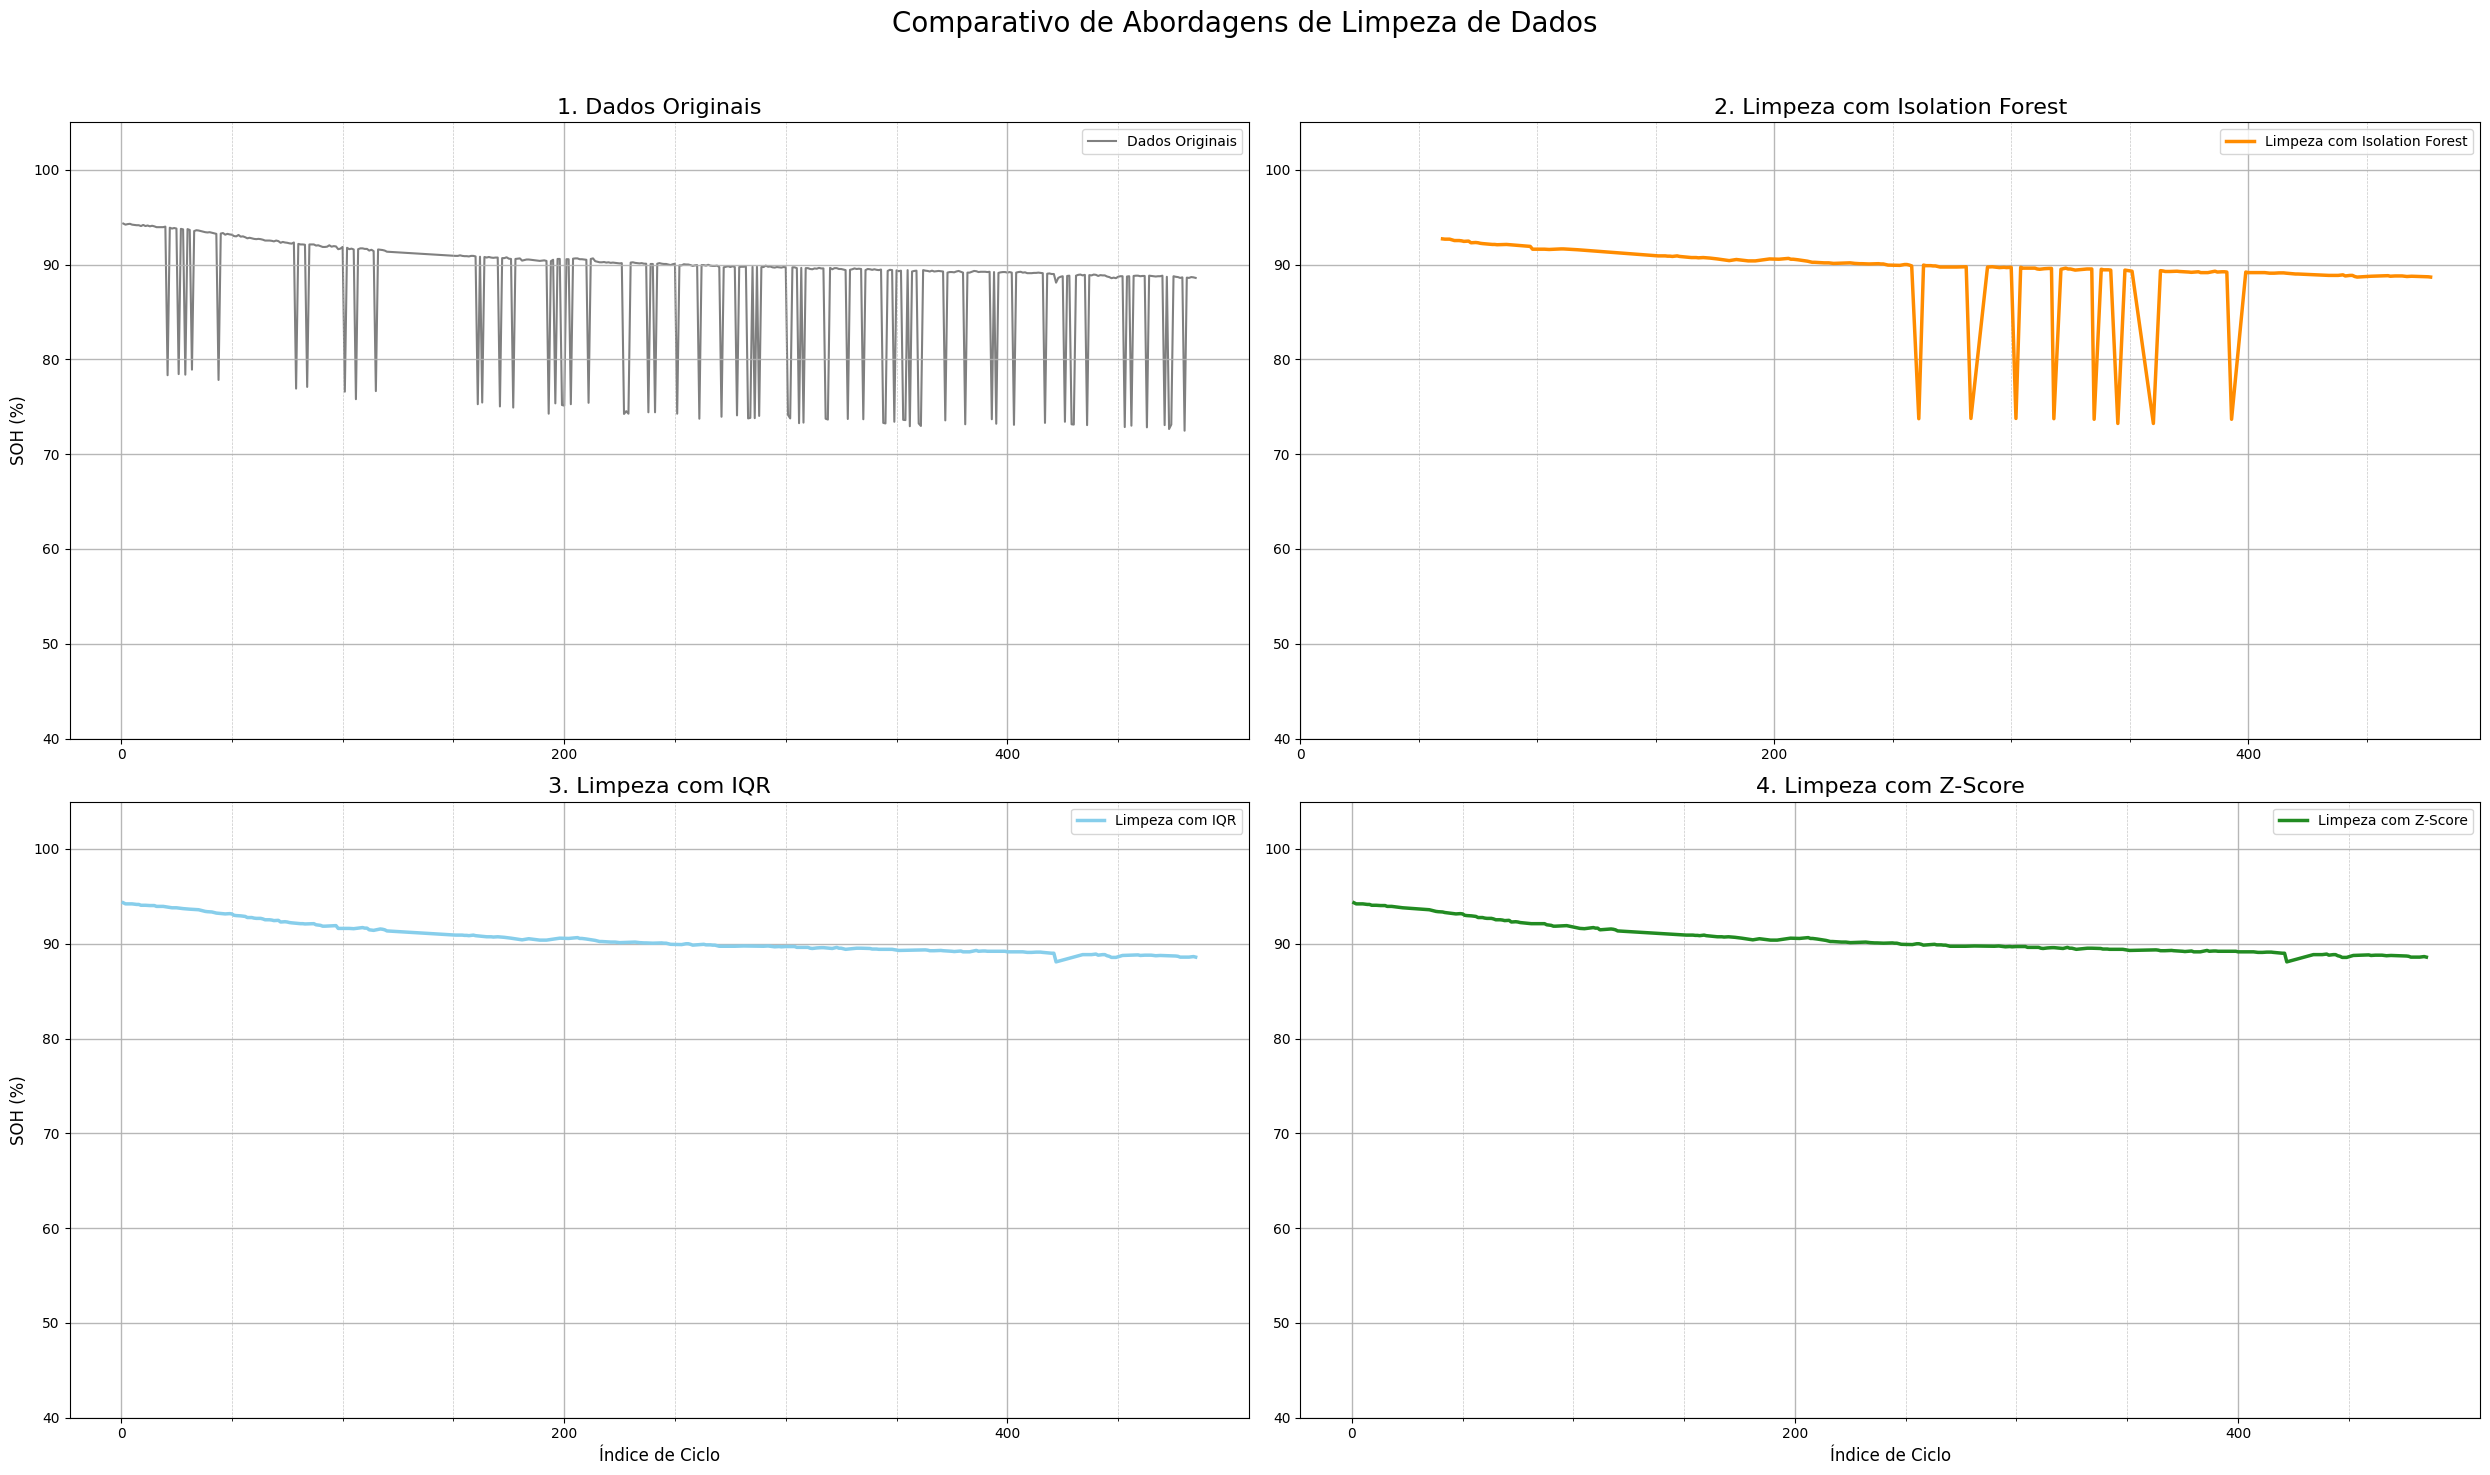

In [31]:
# Crie a figura com 4 subplots em um layout 2x2
fig, axs = plt.subplots(2, 2, figsize=(25, 15))

# Título geral para o plot
fig.suptitle('Comparativo de Abordagens de Limpeza de Dados', fontsize=20)

# Eixo Y compartilhado para padronizar os gráficos
for ax in axs.flat:
    ax.set_ylim(40, 105) # SOH in percentage

# Configuração de Ticks do Eixo X
xmin = df_grouped["Cycle_Index"].min()
xmax = df_grouped["Cycle_Index"].max()
major_ticks = np.arange(0, xmax + 1, 200)
minor_ticks = np.arange(0, xmax + 1, 50)

# 1. Plot para "Dados Originais"
axs[0, 0].plot(df_grouped["Cycle_Index"], df_grouped["SOH_discharge"] * 100, label="Dados Originais", color='gray', linewidth=1.5, zorder=1)
#axs[0, 0].scatter(df_grouped_estimates["estimated_cycle"], df_grouped_estimates["SOH_threshold"] * 100, label="Queda de 1%", color='gray', marker='d', s=100, zorder=3)
axs[0, 0].set_title("1. Dados Originais", fontsize=16)
axs[0, 0].set_ylabel("SOH (%)", fontsize=12)

# 2. Plot para "Isolation Forest"
axs[0, 1].plot(df_IsolForest["Cycle_Index"], df_IsolForest["SOH_discharge"] * 100, label="Limpeza com Isolation Forest", color='darkorange', linewidth=2.5, zorder=2)
# axs[0, 1].scatter(df_IsolForest_estimates["estimated_cycle"], df_IsolForest_estimates["SOH_threshold"] * 100, label="Queda de 1%", color='darkorange', marker='d', s=100, zorder=3)
axs[0, 1].set_title("2. Limpeza com Isolation Forest", fontsize=16)

# 3. Plot para "IQR"
axs[1, 0].plot(df_IQR["Cycle_Index"], df_IQR["SOH_discharge"] * 100, label="Limpeza com IQR", color='skyblue', linewidth=2.5, zorder=2)
# axs[1, 0].scatter(df_IQR_estimates["estimated_cycle"], df_IQR_estimates["SOH_threshold"] * 100, label="Queda de 1%", color='skyblue', marker='d', s=100, zorder=3)
axs[1, 0].set_title("3. Limpeza com IQR", fontsize=16)
axs[1, 0].set_xlabel("Índice de Ciclo", fontsize=12)
axs[1, 0].set_ylabel("SOH (%)", fontsize=12)

# 4. Plot para "Z-Score"
axs[1, 1].plot(df_ZScore["Cycle_Index"], df_ZScore["SOH_discharge"] * 100, label="Limpeza com Z-Score", color='forestgreen', linewidth=2.5, zorder=2)
# axs[1, 1].scatter(df_ZScore_estimates["estimated_cycle"], df_ZScore_estimates["SOH_threshold"] * 100, label="Queda de 1%", color='forestgreen', marker='d', s=100, zorder=3)
axs[1, 1].set_title("4. Limpeza com Z-Score", fontsize=16)
axs[1, 1].set_xlabel("Índice de Ciclo", fontsize=12)

# Adicione grids, ticks e legendas para cada subplot
for ax in axs.flat:
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.grid(which='major', linestyle='-', linewidth=1, alpha=0.9)
    ax.grid(which='minor', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.legend(loc='best', fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## Z-score com ensure_non_decreasing e rmv_sharp_jump é o escolhido

Número de NCD1%: 5
Média: 81.13, Desvio-padrão: 58.47


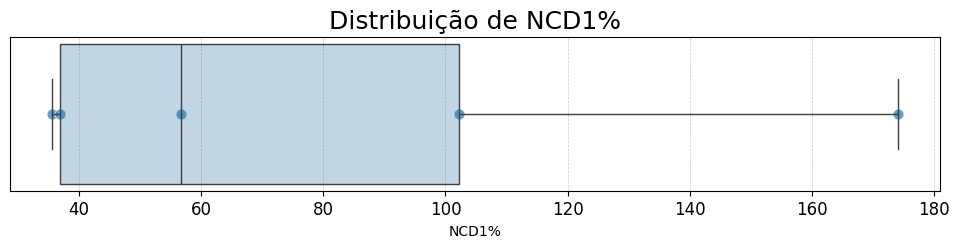

In [32]:
df_ZScore_estimates = rmv_outliers_iqr(df_ZScore_estimates, 'NCD1%')

data = df_ZScore_estimates["NCD1%"].dropna().values
print(f'Número de NCD1%: {len(data)}')

mean = np.mean(data)
std  = np.std(data, ddof=1)
print(f'Média: {mean:.2f}, Desvio-padrão: {std:.2f}')

# Seleciona a cor padrão 'C0' do matplotlib (primeira cor)
default_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
fig, ax = plt.subplots(figsize=(12, 2))

sns.boxplot(
    x=data,                   # valores no eixo x
    y=np.zeros_like(data),    # posição 0 no eixo y
    ax=ax,
    orient='h',
    linewidth=1,
    zorder=2
)

# Deixa a face do boxplot semitransparente
for patch in ax.patches:
    if hasattr(patch, 'get_facecolor'):
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, 0.3))  # alpha = 0.3

# Sobreposição de pontos (scatter) com baixa opacidade
sns.scatterplot(
    x=data,
    y=np.zeros_like(data),
    ax=ax,
    s=60,                     # tamanho dos pontos
    color=default_color,      # mesma cor do boxplot
    alpha=0.7,
    zorder=1
)

# Remove os ticks do eixo y (não fazem sentido aqui)
ax.set_yticks([])

ax.set_xlabel("NCD1%")
ax.tick_params(which='major', labelsize=12)

plt.title("Distribuição de NCD1%", fontsize=18)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.show()

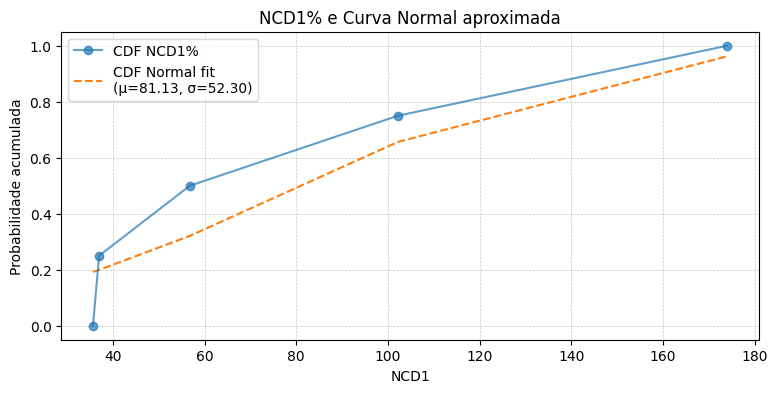

In [33]:
data = np.sort(data)  # Garante que os dados estão ordenados
n    = len(data)

# Faz o fitting para encotnrar os parametros e calcula a funcao acumulada dos dados considerando comportamento normal
mean, std = norm.fit(data)
teo_norm  = norm.cdf(data, loc=mean, scale=std)

plt.figure(figsize=(9, 4))

# Probabilidade acumulada empírica (1/n, 2/n, ..., 1)
cdf_emp = np.arange(0, n)/(n-1)
plt.plot(data, cdf_emp, marker='o', linestyle='-', label="CDF NCD1%", zorder=3, alpha=0.7)

# Função acumulada da normal (teórica)
plt.plot(data, teo_norm, linestyle='--', label=f"CDF Normal fit\n(μ={mean:.2f}, σ={std:.2f})")

plt.xlabel("NCD1")
plt.ylabel("Probabilidade acumulada")
plt.title("NCD1% e Curva Normal aproximada")
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.show()


Teste de Kolmogorov–Smirnov (KS) para verificar formalmente se o conjunto de dados de NCD1% (`data`) segue a distribuição Normal com os parametros encontrados no método de fitting

De acordo com a [documentação de **kstest**](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html):
- ``rvs=data``
    - Array de observações ordenadas
- ``cdf='norm'`` 
    - Especifica que a distribuição teórica é a de uma normal
- ``args=(mean, std)`` 
    - Parâmetros (μ, σ) da normal teórica

Retorna:

- ``D (statistic) `` 
    - Representa a maior diferença absoluta entre aa curva dados e a CDF da Normal teórica
    - Quanto menor, mais próximo o ajuste está dos dados observados

- ``p-value``
    - Probabilidade de observar uma estatística \( D \) igual ou mais extrema sob a suposição de que os dados vêm de uma Normal
    - **Valores altos (> alpha) indicam falha em rejeitar a hipótese de normalidade**. 
    - Valores baixos (< alpha) indicam evidência contra a hipótese

In [34]:
statistic, p_value = kstest(rvs=data, cdf='norm', args=(mean, std))

print(f"KS statistic: {statistic:.4f}")
print(f"p-value: {p_value:.4f}")

alpha = 0.05
print(f'alpha = {alpha}')
if p_value < alpha: print(f"Hipótese rejeitada.")
else: print(f"Hipótese aceita.")

KS statistic: 0.2791
p-value: 0.7444
alpha = 0.05
Hipótese aceita.
